# Model the motion of a two-body system and plot its orbit

In this notebook we create an OrbitSystem object and use it to plot parallax, proper, and orbital motion.

Dependencies:
    astropy, pystrometry

In [1]:
from collections import OrderedDict
import glob
import os
import pprint 

import astropy.constants as constants
from astropy.table import Table, vstack
import astropy.units as u
from IPython.display import display
import matplotlib as mp
import matplotlib.pylab as pl

from pystrometry.pystrometry import OrbitSystem, get_cpsi_spsi_for_2Dastrometry 

##### Setting some defaults

In [2]:
pp = pprint.PrettyPrinter(indent=4)     
%matplotlib inline
mp.rcParams['figure.figsize'] = (18, 9)
mp.rcParams['font.size'] = 20
mp.rcParams['ytick.direction'] = 'in'
mp.rcParams['xtick.direction'] = 'in'

save_plot = True

##### Create temporary directory to save the figure

In [3]:
LOCAL_PATH = os.path.dirname(os.getcwd())
TEMPORARY_DIR = os.path.join(LOCAL_PATH, 'temp')
if os.path.isdir(TEMPORARY_DIR) is False:
    os.makedirs(TEMPORARY_DIR)
print(LOCAL_PATH)

/Users/jsahlmann/code/github/JohannesSahlmann/pystrometry


### Define the system parameters

In [4]:
# GJ 676 A b, see Sahlmann et al. 2016
attribute_dict = OrderedDict([  ('RA_deg', 262.54667), 
                                  ('DE_deg', -51.6369),
                                  ('absolute_plx_mas', 59.3), 
                                  ('Tp_day', 55410.4), 
                                  ('omega_deg', 87.4),
                                  ('P_day', 1052.1), 
                                  ('ecc', 0.323), 
                                  ('OMEGA_deg', 208.),
                                  ('i_deg', 45.), 
                                  ('m1_MS', 0.71),
                                  ('m2_MJ', 6.7), 
                                  ('muRA_mas', -253.4), 
                                  ('muDE_mas', -177.9)])
     

### Compute astrometric motion components (parallax, proper motion, Keplerian orbit)

In [5]:
# instantiate the pystrometry object                             
orb = OrbitSystem(attribute_dict)

# get default times for plotting
t_mjd = orb.get_t_plot(format='mjd')

# compute parallax and proper motion 
delta_ra_star_mas, delta_dec_mas = orb.ppm(t_mjd)

# Generate coefficients to be able to model the data like one-dimensional measurements along the scan angle psi.
# This allows us to use the same formalism for 1D (e.g. from Hipparcos) and 2D (e.g. from an imaging camera or catalog) astrometry
# cpsi == cos(psi); spsi == sin(psi)
# xi and yi are the array indices corresponding to the measurements along perpendicular axes
timestamps_curve_1D, cpsi_curve, spsi_curve, xi_curve, yi_curve = get_cpsi_spsi_for_2Dastrometry( t_mjd )

# compute photocentre orbit (here == barycentre orbit)
# phi0 == along-scan displacement
phi0_curve = orb.photocenter_orbit(timestamps_curve_1D, spsi_curve, cpsi_curve)

# compute relative orbit
phi0_curve_relative = orb.relative_orbit_fast(timestamps_curve_1D, spsi_curve, cpsi_curve, shift_omega_by_pi = True)

#### Plot default orbit figure

No handles with labels found to put in legend.
No handles with labels found to put in legend.


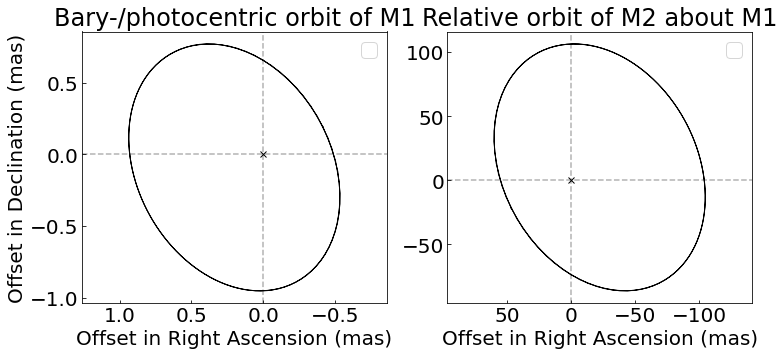

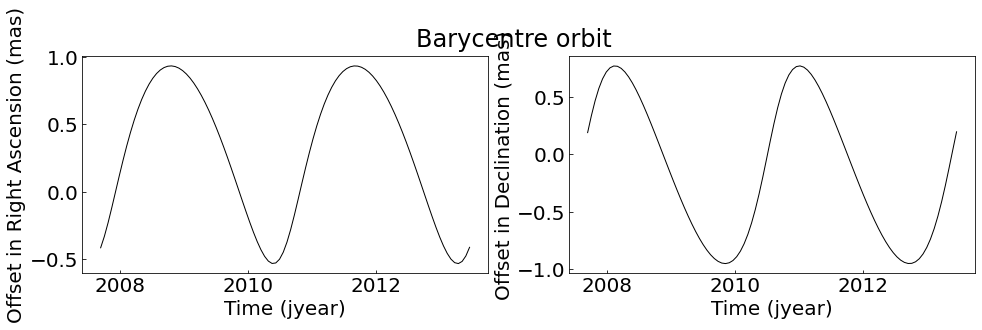

In [6]:
orb.plot_orbits()

## Generate the customised orbit figure

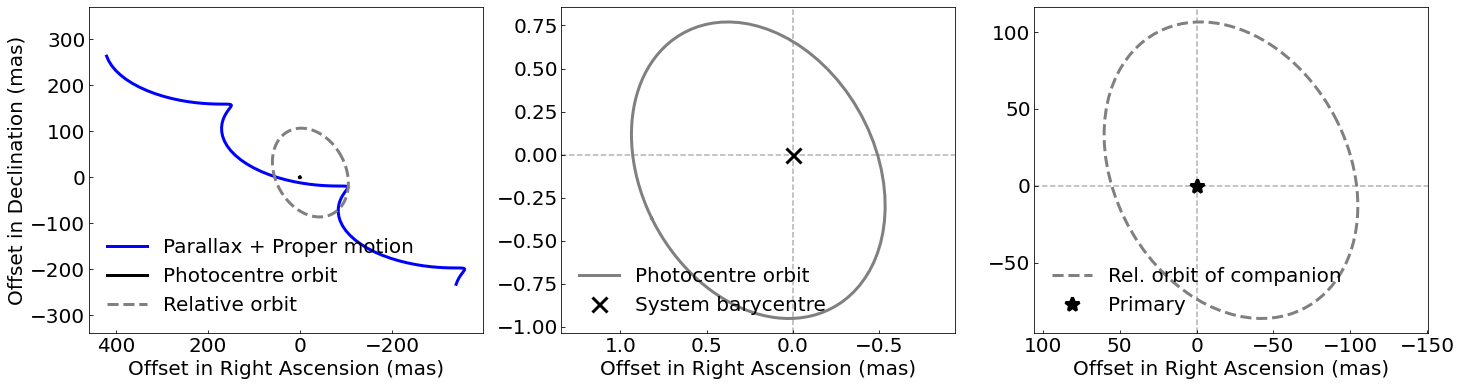

In [7]:
n_figure_columns = 3
n_figure_rows = 1
share_axes = False
line_width = 3
line_color = 'b'
line_style = '-'
orbit_colour = '0.5'

fig, axes = pl.subplots(n_figure_rows, n_figure_columns,
                        figsize=(n_figure_columns * 8, n_figure_rows * 6),
                        facecolor='w', edgecolor='k', sharex=share_axes,
                        sharey=share_axes)

# plot parallax and proper motion
axes[0].plot(delta_ra_star_mas, delta_dec_mas, 'k-', lw=line_width, color=line_color, ls=line_style, label='Parallax + Proper motion')    
axes[0].set_ylabel('Offset in Declination (mas)')
# plot photocentre orbit
axes[0].plot(phi0_curve[xi_curve], phi0_curve[yi_curve],'k--', lw=line_width, color='k', ls=line_style, label='Photocentre orbit')
# plot relative orbit
axes[0].plot(phi0_curve_relative[xi_curve], phi0_curve_relative[yi_curve],'k--', lw=line_width, color=orbit_colour, ls='--', label='Relative orbit')

# plot photocentre orbit in separate panel
axes[1].plot(phi0_curve[xi_curve], phi0_curve[yi_curve],'k--', lw=line_width, color=orbit_colour, ls=line_style, label='Photocentre orbit')
axes[1].plot(0,0,'kx', ms=15, mew=3, label='System barycentre')

# plot relative orbit
axes[2].plot(phi0_curve_relative[xi_curve], phi0_curve_relative[yi_curve],'k--', lw=line_width, color=orbit_colour, ls='--', label='Rel. orbit of companion')
axes[2].plot(0,0,'k*', ms=15, mew=3, label='Primary')

for ax in axes:
    ax.legend(loc=3, fancybox=True, framealpha=0.)
    ax.axis('equal')
    ax.set_xlabel('Offset in Right Ascension (mas)')
    ax.invert_xaxis()

for ax in axes[1:]:    
    ax.axhline(y=0,color='0.7',ls='--',zorder=-50)
    ax.axvline(x=0,color='0.7',ls='--',zorder=-50)
    
pl.show()    
if save_plot:
    figure_file_name = os.path.join(TEMPORARY_DIR, 'example_orbit.png')
    fig.savefig(figure_file_name, transparent=True, bbox_inches='tight', pad_inches=0.05)        